## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

C:\Users\ladwi\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:5


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of          depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0            1     -2.989824     551.514698   -19.194445     -28.116538   
1            2     -2.989824     551.514698   -19.194445     -28.116538   
2            3     -2.989824     551.514698   -19.194445     -28.116538   
3            4     -2.989824     551.514698   -19.194445     -28.116538   
4            5     -2.989824     551.514698   -19.194445     -28.116538   
...        ...           ...            ...          ...            ...   
2628545     46    -12.920028     494.226632   -46.982710     -95.220702   
2628546     47    -12.920028     494.226632   -46.982710     -95.220702   
2628547     48    -12.920028     494.226632   -46.982710     -95.220702   
2628548     49    -12.920028     494.226632   -46.982710     -95.220702   
2628549     50    -12.920028     494.226632   -46.982710     -95.220702   

         Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0   

In [5]:
training_frac = 0.60
depth_steps = 50
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 52571
Number of training points: 1577100


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_conv04']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 'Uw',
                 'day_of_year', 'time_of_day', 'temp_initial00'] #,  
               #  'buoyancy', 'diffusivity', 'temp_initial00', 
               # 'temp_heat01', 'temp_diff02', 'temp_total05',
               # 'ice', 'snow', 'snowice'
m0_output_columns =['temp_conv04']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/direct_model_train_pb_time.pth"
m0_layers = [len(m0_input_columns), 32, 32,32,32,32,32,32,32,32,32, len(m0_output_columns)]

direct_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
direct_model.load_state_dict(m0_checkpoint)
direct_model = direct_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

## Mixing Model

# Convection Model

# Ice Model

In [9]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [10]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [11]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [12]:
# Create data set
batch_size = 1000

#assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [13]:
print(train_data.shape)
print(test_data.shape)

(1577100, 45)
(1051450, 45)


In [14]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [15]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [16]:
def get_rollout_predictions(direct_model, loader, plot = True):    
    direct_model.eval()

    mean = torch.tensor(train_mean[m0_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m0_output_column_ix]).float().to(device)


#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = direct_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        y_true = x[:, m0_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m0_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [17]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [18]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(direct_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0771661
RMSE of after m0 0.24895063
RMSE of after m0 0.089507304
RMSE of after m0 0.14248642
RMSE of after m0 0.01820331
RMSE of after m0 0.013313463
RMSE of after m0 0.0087977005
RMSE of after m0 0.008811412
RMSE of after m0 0.01107982
RMSE of after m0 0.010878513
RMSE of after m0 0.009298528
RMSE of after m0 0.013368238
RMSE of after m0 0.011603065
RMSE of after m0 0.011497208
RMSE of after m0 0.035607837
RMSE of after m0 0.037117288
RMSE of after m0 0.030203486
RMSE of after m0 0.020617822
RMSE of after m0 0.019854419
RMSE of after m0 0.016890913
RMSE of after m0 0.018503623
RMSE of after m0 0.027579037
RMSE of after m0 0.021931497
RMSE of after m0 0.030091053
RMSE of after m0 0.018060671
RMSE of after m0 0.013982979
RMSE of after m0 0.023761418
RMSE of after m0 0.013032203
RMSE of after m0 0.0181701
RMSE of after m0 0.014247098
RMSE of after m0 0.021133067
RMSE of after m0 0.02275569
RMSE of after m0 0.022810102
RMSE of after m0 0.019711355
RMSE of after m0 0.021

RMSE of after m0 0.060174312
RMSE of after m0 0.052006185
RMSE of after m0 0.047224972
RMSE of after m0 0.048664473
RMSE of after m0 0.053533487
RMSE of after m0 0.07893169
RMSE of after m0 0.04572167
RMSE of after m0 0.05668496
RMSE of after m0 0.055397756
RMSE of after m0 0.046852022
RMSE of after m0 0.048915867
RMSE of after m0 0.051454276
RMSE of after m0 0.07816852
RMSE of after m0 0.053339444
RMSE of after m0 0.055998158
RMSE of after m0 0.05525684
RMSE of after m0 0.041489296
RMSE of after m0 0.034228362
RMSE of after m0 0.04794505
RMSE of after m0 0.059938315
RMSE of after m0 0.03885367
RMSE of after m0 0.037771165
RMSE of after m0 0.031752773
RMSE of after m0 0.02809885
RMSE of after m0 0.026903775
RMSE of after m0 0.031215781
RMSE of after m0 0.048299737
RMSE of after m0 0.04348383
RMSE of after m0 0.037737314
RMSE of after m0 0.061959628
RMSE of after m0 0.03149115
RMSE of after m0 0.028840654
RMSE of after m0 0.044774286
RMSE of after m0 0.021212438
RMSE of after m0 0.02395

RMSE of after m0 0.013524767
RMSE of after m0 0.018819219
RMSE of after m0 0.023993412
RMSE of after m0 0.013052937
RMSE of after m0 0.056015287
RMSE of after m0 0.046655305
RMSE of after m0 0.112000234
RMSE of after m0 0.028645605
RMSE of after m0 0.038732167
RMSE of after m0 0.031319916
RMSE of after m0 0.040446565
RMSE of after m0 0.03131442
RMSE of after m0 0.021071846
RMSE of after m0 0.016679212
RMSE of after m0 0.017971229
RMSE of after m0 0.018371982
RMSE of after m0 0.017264584
RMSE of after m0 0.016101643
RMSE of after m0 0.06339034
RMSE of after m0 0.041696887
RMSE of after m0 0.046058685
RMSE of after m0 0.045165587
RMSE of after m0 0.066262744
RMSE of after m0 0.051167674
RMSE of after m0 0.03565382
RMSE of after m0 0.016975267
RMSE of after m0 0.019842241
RMSE of after m0 0.026481135
RMSE of after m0 0.027024623
RMSE of after m0 0.07874688
RMSE of after m0 0.06691952
RMSE of after m0 0.043689515
RMSE of after m0 0.023716068
RMSE of after m0 0.0368494
RMSE of after m0 0.05

RMSE of after m0 0.023703314
RMSE of after m0 0.014055081
RMSE of after m0 0.02329125
RMSE of after m0 0.025840089
RMSE of after m0 0.010146791
RMSE of after m0 0.012999322
RMSE of after m0 0.015042709
RMSE of after m0 0.014055964
RMSE of after m0 0.03451833
RMSE of after m0 0.013767792
RMSE of after m0 0.023701055
RMSE of after m0 0.015523017
RMSE of after m0 0.0154810455
RMSE of after m0 0.030116167
RMSE of after m0 0.017520506
RMSE of after m0 0.016388338
RMSE of after m0 0.013563663
RMSE of after m0 0.016213348
RMSE of after m0 0.01589505
RMSE of after m0 0.015126385
RMSE of after m0 0.016767187
RMSE of after m0 0.017380467
RMSE of after m0 0.017412016
RMSE of after m0 0.018995618
RMSE of after m0 0.020521939
RMSE of after m0 0.022207923
RMSE of after m0 0.018883301
RMSE of after m0 0.03274353
RMSE of after m0 0.032315757
RMSE of after m0 0.023013633
RMSE of after m0 0.0229575
RMSE of after m0 0.021121513
RMSE of after m0 0.023022557
RMSE of after m0 0.02154837
RMSE of after m0 0.0

RMSE of after m0 0.03101858
RMSE of after m0 0.030383458
RMSE of after m0 0.03564776
RMSE of after m0 0.0924686
RMSE of after m0 0.05656384
RMSE of after m0 0.027346266
RMSE of after m0 0.041718863
RMSE of after m0 0.027458442
RMSE of after m0 0.0432516
RMSE of after m0 0.020515848
RMSE of after m0 0.029558044
RMSE of after m0 0.021274272
RMSE of after m0 0.021850511
RMSE of after m0 0.031477243
RMSE of after m0 0.08303226
RMSE of after m0 0.03858988
RMSE of after m0 0.04430227
RMSE of after m0 0.030106828
RMSE of after m0 0.023638515
RMSE of after m0 0.026073612
RMSE of after m0 0.023418741
RMSE of after m0 0.02152576
RMSE of after m0 0.023425767
RMSE of after m0 0.022370845
RMSE of after m0 0.02082164
RMSE of after m0 0.021795137
RMSE of after m0 0.03027391
RMSE of after m0 0.04061325
RMSE of after m0 0.030718347
RMSE of after m0 0.026399184
RMSE of after m0 0.048677027
RMSE of after m0 0.060229212
RMSE of after m0 0.03784961
RMSE of after m0 0.021519305
RMSE of after m0 0.019328134


RMSE of after m0 0.032576416
RMSE of after m0 0.025297675
RMSE of after m0 0.03260302
RMSE of after m0 0.029436719
RMSE of after m0 0.03529942
RMSE of after m0 0.032814518
RMSE of after m0 0.028146802
RMSE of after m0 0.020224769
RMSE of after m0 0.027028322
RMSE of after m0 0.045291726
RMSE of after m0 0.024490174
RMSE of after m0 0.030537076
RMSE of after m0 0.088097885
RMSE of after m0 0.051353
RMSE of after m0 0.046772424
RMSE of after m0 0.01744571
RMSE of after m0 0.02031056
RMSE of after m0 0.029448392
RMSE of after m0 0.018551478
RMSE of after m0 0.022543015
RMSE of after m0 0.033499956
RMSE of after m0 0.06838896
RMSE of after m0 0.066100456
RMSE of after m0 0.04924543
RMSE of after m0 0.033246282
RMSE of after m0 0.027241256
RMSE of after m0 0.027594473
RMSE of after m0 0.0353309
RMSE of after m0 0.055514507
RMSE of after m0 0.051098537
RMSE of after m0 0.035972863
RMSE of after m0 0.030157018
RMSE of after m0 0.04318454
RMSE of after m0 0.041671082
RMSE of after m0 0.0359191

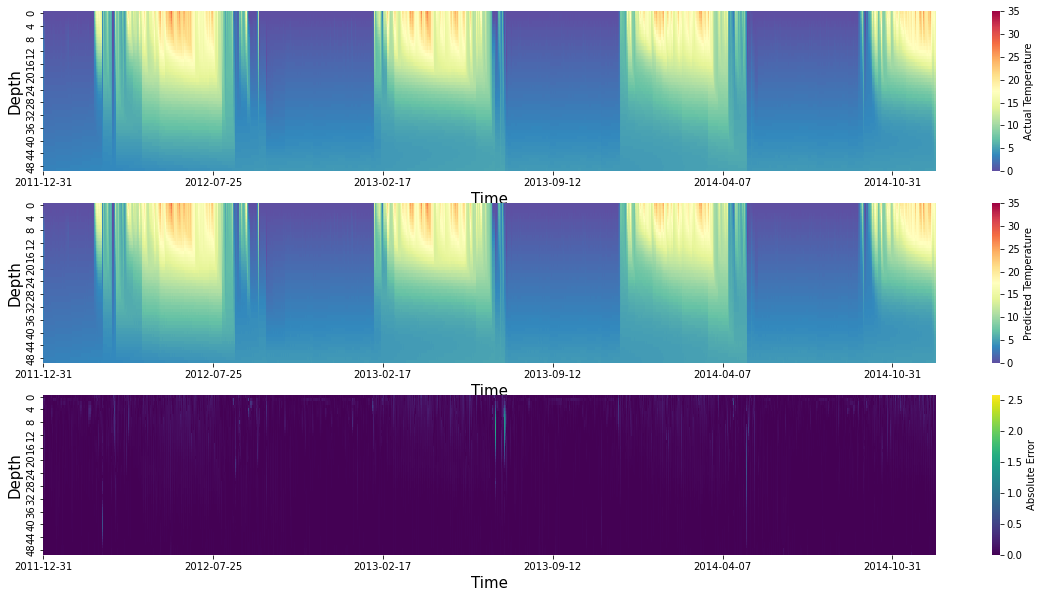

In [19]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

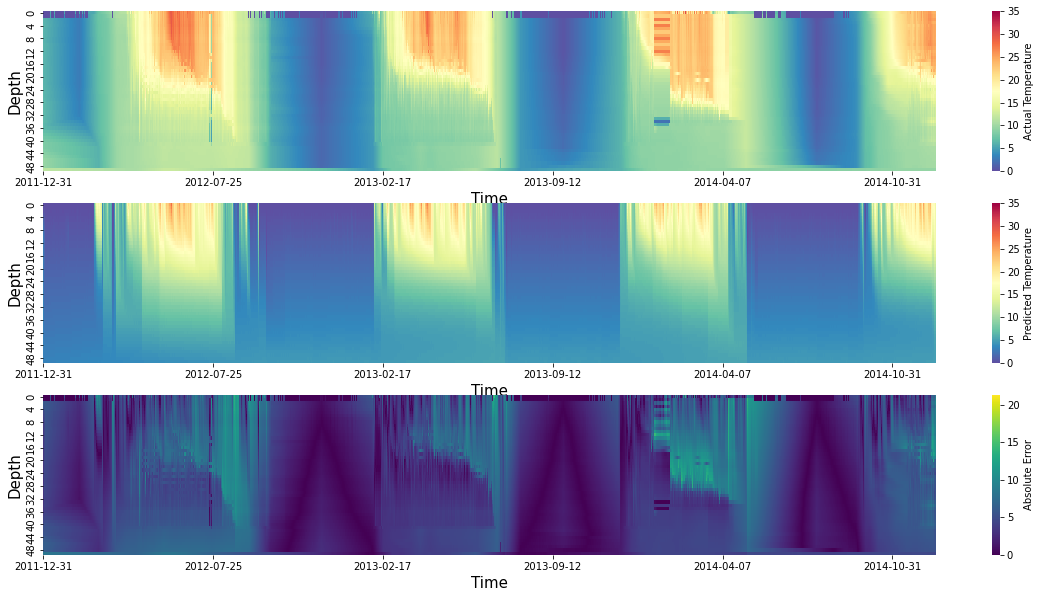

In [20]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [21]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(direct_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.03885577
RMSE of after m0 0.056742877
RMSE of after m0 0.051499303
RMSE of after m0 0.04291746
RMSE of after m0 0.042545635
RMSE of after m0 0.04446697
RMSE of after m0 0.043656975
RMSE of after m0 0.04016462
RMSE of after m0 0.040501058
RMSE of after m0 0.05105792
RMSE of after m0 0.04279092
RMSE of after m0 0.043503232
RMSE of after m0 0.056032006
RMSE of after m0 0.048983514
RMSE of after m0 0.04853627
RMSE of after m0 0.07331778
RMSE of after m0 0.11506193
RMSE of after m0 0.0598761
RMSE of after m0 0.07569506
RMSE of after m0 0.08950982
RMSE of after m0 0.07538368
RMSE of after m0 0.060381737
RMSE of after m0 0.053036507
RMSE of after m0 0.03897003
RMSE of after m0 0.026920816
RMSE of after m0 0.030623395
RMSE of after m0 0.028288612
RMSE of after m0 0.045315035
RMSE of after m0 0.0318678
RMSE of after m0 0.032358274
RMSE of after m0 0.04903093
RMSE of after m0 0.06678286
RMSE of after m0 0.0484553
RMSE of after m0 0.057550862
RMSE of after m0 0.047447458
RMSE o

RMSE of after m0 0.013553573
RMSE of after m0 0.025086733
RMSE of after m0 0.012359359
RMSE of after m0 0.012427801
RMSE of after m0 0.015430572
RMSE of after m0 0.024173522
RMSE of after m0 0.009624158
RMSE of after m0 0.041030925
RMSE of after m0 0.02265019
RMSE of after m0 0.03799239
RMSE of after m0 0.026717084
RMSE of after m0 0.032802563
RMSE of after m0 0.054313168
RMSE of after m0 0.04836738
RMSE of after m0 0.03235875
RMSE of after m0 0.013480437
RMSE of after m0 0.018691884
RMSE of after m0 0.023023726
RMSE of after m0 0.0296579
RMSE of after m0 0.039466962
RMSE of after m0 0.03341032
RMSE of after m0 0.028718019
RMSE of after m0 0.075168006
RMSE of after m0 0.036156956
RMSE of after m0 0.021802388
RMSE of after m0 0.024773663
RMSE of after m0 0.052387178
RMSE of after m0 0.025397813
RMSE of after m0 0.02056054
RMSE of after m0 0.021948352
RMSE of after m0 0.023594184
RMSE of after m0 0.029626576
RMSE of after m0 0.015939478
RMSE of after m0 0.029384254
RMSE of after m0 0.041

RMSE of after m0 0.02177061
RMSE of after m0 0.024013624
RMSE of after m0 0.013696424
RMSE of after m0 0.007897711
RMSE of after m0 0.008481187
RMSE of after m0 0.010175294
RMSE of after m0 0.011464385
RMSE of after m0 0.008272741
RMSE of after m0 0.015848909
RMSE of after m0 0.02851715
RMSE of after m0 0.012120617
RMSE of after m0 0.007535279
RMSE of after m0 0.013740001
RMSE of after m0 0.040206194
RMSE of after m0 0.041427217
RMSE of after m0 0.044756748
RMSE of after m0 0.015345975
RMSE of after m0 0.010776663
RMSE of after m0 0.010109709
RMSE of after m0 0.008192905
RMSE of after m0 0.012654531
RMSE of after m0 0.013844566
RMSE of after m0 0.034823697
RMSE of after m0 0.0388021
RMSE of after m0 0.015484582
RMSE of after m0 0.013119606
RMSE of after m0 0.014152086
RMSE of after m0 0.023535013
RMSE of after m0 0.009780369
RMSE of after m0 0.011557296
RMSE of after m0 0.010846822
RMSE of after m0 0.010690539
RMSE of after m0 0.012748054
RMSE of after m0 0.060399476
RMSE of after m0 0

RMSE of after m0 0.089390226
RMSE of after m0 0.042483147
RMSE of after m0 0.032208517
RMSE of after m0 0.034776025
RMSE of after m0 0.042920172
RMSE of after m0 0.045542
RMSE of after m0 0.0502077
RMSE of after m0 0.074991405
RMSE of after m0 0.05019858
RMSE of after m0 0.047063794
RMSE of after m0 0.046293993
RMSE of after m0 0.044753205
RMSE of after m0 0.04641728
RMSE of after m0 0.05413292
RMSE of after m0 0.058326054
RMSE of after m0 0.09871477
RMSE of after m0 0.13720886
RMSE of after m0 0.064590745
RMSE of after m0 0.04744095
RMSE of after m0 0.05843877
RMSE of after m0 0.0486875
RMSE of after m0 0.060374513
RMSE of after m0 0.111316144
RMSE of after m0 0.056493588
RMSE of after m0 0.036211345
RMSE of after m0 0.04746188
RMSE of after m0 0.03987346
RMSE of after m0 0.064991646
RMSE of after m0 0.06290349
RMSE of after m0 0.034594662
RMSE of after m0 0.042619124
RMSE of after m0 0.047580007
RMSE of after m0 0.059006296
RMSE of after m0 0.078872025
RMSE of after m0 0.04718121
RMS

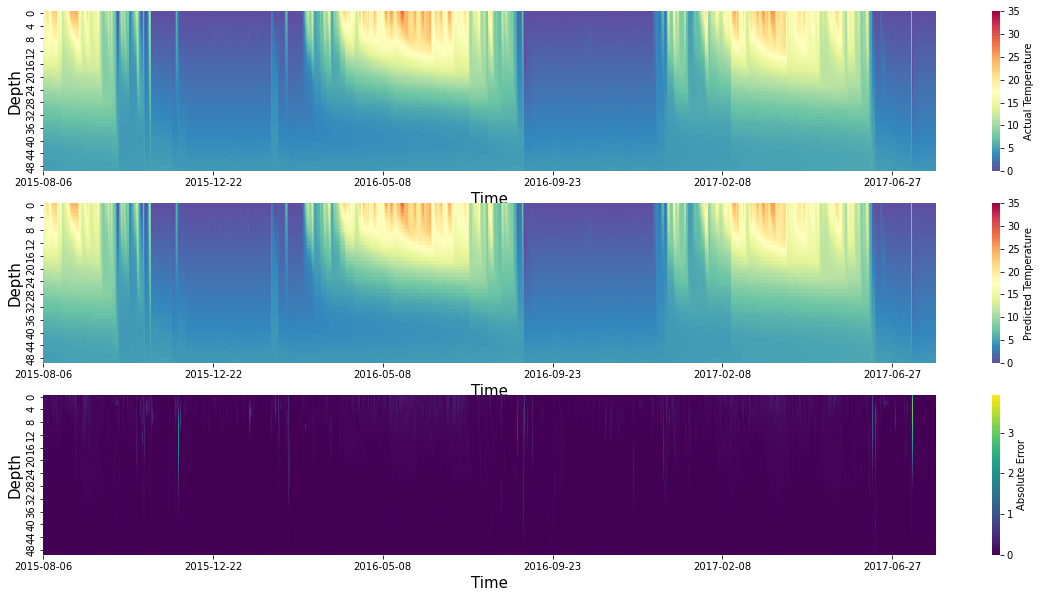

In [22]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

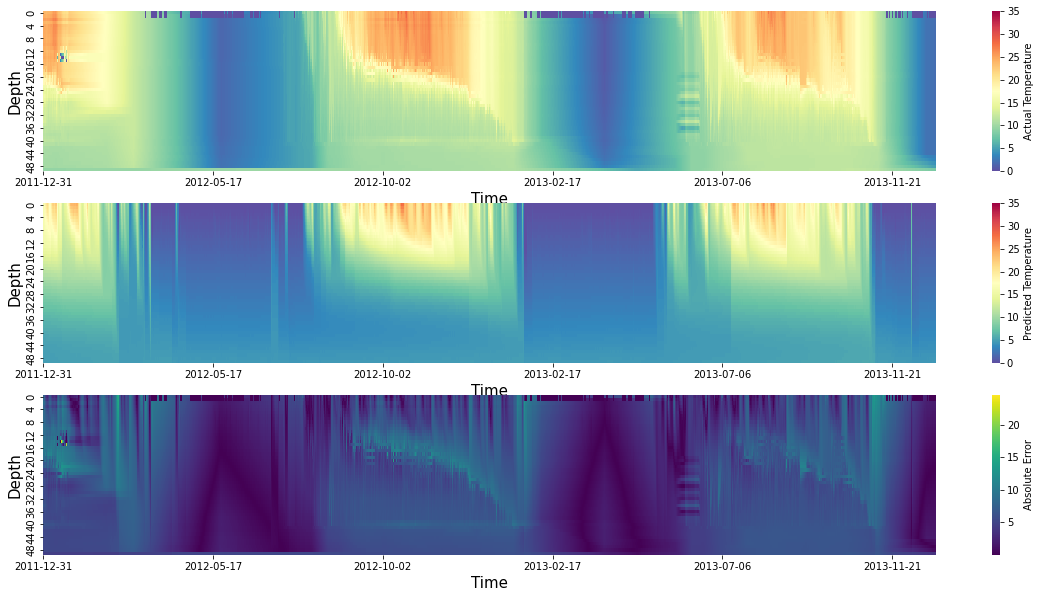

In [23]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [24]:
train_rmse, train_l2_err = compute_metrics( direct_model, train_loader, m0_input_column_ix, m0_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(direct_model, test_loader, m0_input_column_ix, m0_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.046175141791731975, Train L2 Error: 0.006080920258186743
Test RMSE: 0.06804321214432899, Train L2 Error: 0.008554532290753099


## Mixing Model

## Convection Model

## Ice Model

# Finetuning

In [25]:
lr = 1e-5
# decay_rate = 0.1
# decay_steps = 500

params = list(direct_model.parameters()) 
optimizer = torch.optim.Adam(params, lr=lr, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

# Freeze model weights

In [26]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [27]:
#freeze_model(heating_model)

unfreeze_model(direct_model)


# Finetuning on Observed Temperature

In [28]:
direct_model.train()


n_epochs = 1000

# mean and standard dev of "temp_total04" of model 4 output
mean_out0 = torch.tensor(train_mean[m0_output_column_ix[0]]).float().to(device)
std_out0 = torch.tensor(train_std[m0_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input

train_loss = []
LOSS_m0 = []


for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    loss_epoch_m0 = 0

    for ix, x in enumerate(iter(train_loader)):
        x = x.to(device).float()
        optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
        m0_input = x[:, m0_input_column_ix]
        
        #model 0
        m0_pred = direct_model(m0_input) #predicts diff and temp
        
        obs_temp_true = x[:, obs_temp_columns_ix] * std_obs + mean_obs
        obs_temp_true_norm = (obs_temp_true - mean_out0)/std_out0
        
        loss_m0 = criterion(m0_pred, obs_temp_true_norm)

        #loss = (loss_m0 + loss_m1 + loss_m2 + loss_m3 + loss_m4)
        
        loss = loss_m0
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        loss_epoch_m0 += loss_m0.item()

    loss_epoch = loss_epoch/len(train_loader)
    loss_epoch_m0 = loss_epoch_m0/len(train_loader)

    train_loss.append(loss_epoch)
    LOSS_m0.append(loss_epoch_m0)

    if it % 50 == 0:
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Loss m0: {LOSS_m0[-1]}")
    
    #plot the loss_m1, m2


  0%|          | 1/1000 [00:23<6:39:26, 23.99s/it]

Epoch : 0, Train_loss: 0.6508355054954782, Loss m0: 0.6508355054954782


  5%|▌         | 51/1000 [20:27<6:14:36, 23.68s/it]

Epoch : 50, Train_loss: 0.13356288356283924, Loss m0: 0.13356288356283924


 10%|█         | 101/1000 [40:24<5:57:33, 23.86s/it]

Epoch : 100, Train_loss: 0.11206734622887682, Loss m0: 0.11206734622887682


 15%|█▌        | 151/1000 [1:00:20<5:40:19, 24.05s/it]

Epoch : 150, Train_loss: 0.10128683321731559, Loss m0: 0.10128683321731559


 20%|██        | 201/1000 [1:20:12<5:17:57, 23.88s/it]

Epoch : 200, Train_loss: 0.09310823105628566, Loss m0: 0.09310823105628566


 25%|██▌       | 251/1000 [1:40:05<4:57:42, 23.85s/it]

Epoch : 250, Train_loss: 0.08687362452751765, Loss m0: 0.08687362452751765


 30%|███       | 301/1000 [2:00:01<4:39:31, 23.99s/it]

Epoch : 300, Train_loss: 0.08228787027490626, Loss m0: 0.08228787027490626


 35%|███▌      | 351/1000 [2:19:52<4:16:27, 23.71s/it]

Epoch : 350, Train_loss: 0.07868795338026584, Loss m0: 0.07868795338026584


 40%|████      | 401/1000 [2:39:43<3:57:25, 23.78s/it]

Epoch : 400, Train_loss: 0.07562572438448682, Loss m0: 0.07562572438448682


 45%|████▌     | 451/1000 [2:59:33<3:38:38, 23.90s/it]

Epoch : 450, Train_loss: 0.07325209751421248, Loss m0: 0.07325209751421248


 50%|█████     | 501/1000 [3:19:18<3:21:26, 24.22s/it]

Epoch : 500, Train_loss: 0.0713557070979898, Loss m0: 0.0713557070979898


 55%|█████▌    | 551/1000 [3:39:04<2:57:22, 23.70s/it]

Epoch : 550, Train_loss: 0.06982070009188115, Loss m0: 0.06982070009188115


 60%|██████    | 601/1000 [3:58:52<2:38:17, 23.80s/it]

Epoch : 600, Train_loss: 0.06849400732012322, Loss m0: 0.06849400732012322


 65%|██████▌   | 651/1000 [4:18:42<2:18:34, 23.82s/it]

Epoch : 650, Train_loss: 0.06736563114207109, Loss m0: 0.06736563114207109


 70%|███████   | 701/1000 [4:38:48<2:04:27, 24.98s/it]

Epoch : 700, Train_loss: 0.06637119087248955, Loss m0: 0.06637119087248955


 75%|███████▌  | 751/1000 [4:59:39<1:45:11, 25.35s/it]

Epoch : 750, Train_loss: 0.06541384384124593, Loss m0: 0.06541384384124593


 80%|████████  | 801/1000 [5:20:21<1:18:58, 23.81s/it]

Epoch : 800, Train_loss: 0.06452705056293831, Loss m0: 0.06452705056293831


 85%|████████▌ | 851/1000 [5:40:17<59:07, 23.81s/it]  

Epoch : 850, Train_loss: 0.06380042836411781, Loss m0: 0.06380042836411781


 90%|█████████ | 901/1000 [5:59:45<41:29, 25.15s/it]

Epoch : 900, Train_loss: 0.06324800568966535, Loss m0: 0.06324800568966535


 95%|█████████▌| 951/1000 [6:21:14<21:05, 25.82s/it]

Epoch : 950, Train_loss: 0.06280958129202827, Loss m0: 0.06280958129202827


100%|██████████| 1000/1000 [6:42:32<00:00, 24.15s/it]


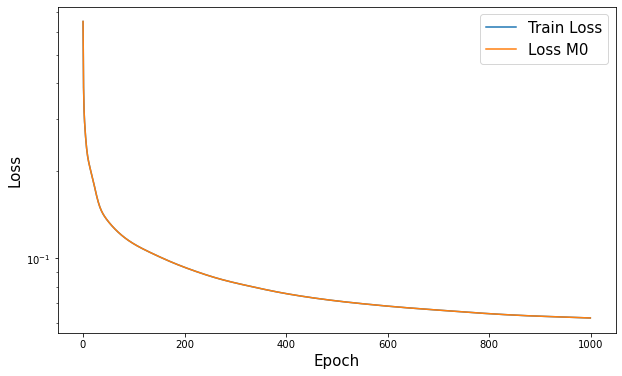

In [29]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label = "Train Loss")
plt.plot(LOSS_m0, label = "Loss M0")

plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)
plt.show()

# Rollout Evaluation After FineTuning

In [30]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(direct_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 4.1038327
RMSE of after m0 4.2733207
RMSE of after m0 4.7877502
RMSE of after m0 4.543032
RMSE of after m0 4.6211033
RMSE of after m0 4.688069
RMSE of after m0 4.6749234
RMSE of after m0 4.6419516
RMSE of after m0 4.5275908
RMSE of after m0 4.5725107
RMSE of after m0 4.4759135
RMSE of after m0 4.560718
RMSE of after m0 4.6635756
RMSE of after m0 4.6237874
RMSE of after m0 4.4718895
RMSE of after m0 4.403025
RMSE of after m0 4.3108006
RMSE of after m0 4.092612
RMSE of after m0 4.09397
RMSE of after m0 4.2948017
RMSE of after m0 4.120412
RMSE of after m0 4.0137734
RMSE of after m0 3.9818141
RMSE of after m0 4.043922
RMSE of after m0 3.7720196
RMSE of after m0 3.6617827
RMSE of after m0 3.7135978
RMSE of after m0 4.0147243
RMSE of after m0 3.7152126
RMSE of after m0 3.6758702
RMSE of after m0 3.5364523
RMSE of after m0 3.4581974
RMSE of after m0 3.409149
RMSE of after m0 3.410184
RMSE of after m0 3.4285078
RMSE of after m0 3.3356063
RMSE of after m0 3.3274171
RMSE of afte

RMSE of after m0 8.58244
RMSE of after m0 8.592184
RMSE of after m0 8.562597
RMSE of after m0 8.531087
RMSE of after m0 8.446025
RMSE of after m0 8.354777
RMSE of after m0 8.28243
RMSE of after m0 8.237604
RMSE of after m0 8.091967
RMSE of after m0 7.993144
RMSE of after m0 7.9261646
RMSE of after m0 7.9536495
RMSE of after m0 8.45987
RMSE of after m0 9.428207
RMSE of after m0 9.477283
RMSE of after m0 9.6966505
RMSE of after m0 10.463808
RMSE of after m0 9.871078
RMSE of after m0 10.118053
RMSE of after m0 10.239818
RMSE of after m0 10.017509
RMSE of after m0 10.048829
RMSE of after m0 9.509621
RMSE of after m0 8.728884
RMSE of after m0 8.491735
RMSE of after m0 8.342805
RMSE of after m0 7.987401
RMSE of after m0 7.8436594
RMSE of after m0 8.011761
RMSE of after m0 7.9371076
RMSE of after m0 7.8525953
RMSE of after m0 7.763
RMSE of after m0 7.581538
RMSE of after m0 7.3550363
RMSE of after m0 7.0133386
RMSE of after m0 6.7894063
RMSE of after m0 6.672161
RMSE of after m0 7.0441947
RMS

RMSE of after m0 4.6869035
RMSE of after m0 4.760559
RMSE of after m0 4.897774
RMSE of after m0 4.954058
RMSE of after m0 4.948697
RMSE of after m0 4.8432546
RMSE of after m0 4.8588114
RMSE of after m0 4.793235
RMSE of after m0 4.7551985
RMSE of after m0 4.7953224
RMSE of after m0 4.733698
RMSE of after m0 4.887383
RMSE of after m0 4.921272
RMSE of after m0 4.9946685
RMSE of after m0 5.1968575
RMSE of after m0 5.317916
RMSE of after m0 5.4281635
RMSE of after m0 5.310065
RMSE of after m0 5.303517
RMSE of after m0 5.4027724
RMSE of after m0 5.4356256
RMSE of after m0 5.427571
RMSE of after m0 5.3842907
RMSE of after m0 5.3818717
RMSE of after m0 5.315196
RMSE of after m0 5.3322144
RMSE of after m0 5.3987255
RMSE of after m0 5.2409678
RMSE of after m0 5.204918
RMSE of after m0 5.3042893
RMSE of after m0 5.4399657
RMSE of after m0 5.4409685
RMSE of after m0 5.4519615
RMSE of after m0 5.4695477
RMSE of after m0 5.4763265
RMSE of after m0 5.471096
RMSE of after m0 5.552388
RMSE of after m0 

RMSE of after m0 1.1689216
RMSE of after m0 1.0775387
RMSE of after m0 1.0375897
RMSE of after m0 1.0599589
RMSE of after m0 1.1750379
RMSE of after m0 1.106731
RMSE of after m0 1.0346678
RMSE of after m0 1.1450974
RMSE of after m0 1.1211358
RMSE of after m0 1.2082614
RMSE of after m0 1.2941675
RMSE of after m0 1.1691366
RMSE of after m0 1.2046936
RMSE of after m0 1.2405896
RMSE of after m0 1.2290535
RMSE of after m0 1.3145503
RMSE of after m0 1.3468896
RMSE of after m0 1.3355097
RMSE of after m0 1.2915189
RMSE of after m0 1.5247637
RMSE of after m0 1.4518431
RMSE of after m0 1.4176673
RMSE of after m0 1.4291846
RMSE of after m0 1.5291098
RMSE of after m0 1.533123
RMSE of after m0 1.7828543
RMSE of after m0 1.7636957
RMSE of after m0 1.7435971
RMSE of after m0 1.6401131
RMSE of after m0 1.8280444
RMSE of after m0 2.0435648
RMSE of after m0 2.5989783
RMSE of after m0 1.9649036
RMSE of after m0 1.971104
RMSE of after m0 2.089359
RMSE of after m0 2.0623174
RMSE of after m0 2.0706487
RMSE 

RMSE of after m0 7.984
RMSE of after m0 7.2112794
RMSE of after m0 7.380191
RMSE of after m0 7.684525
RMSE of after m0 6.5190606
RMSE of after m0 6.157927
RMSE of after m0 6.196398
RMSE of after m0 5.79434
RMSE of after m0 5.9832873
RMSE of after m0 5.9844995
RMSE of after m0 5.502051
RMSE of after m0 6.7309456
RMSE of after m0 5.861852
RMSE of after m0 5.023088
RMSE of after m0 4.7979307
RMSE of after m0 5.927342
RMSE of after m0 6.188993
RMSE of after m0 5.3567414
RMSE of after m0 5.4781404
RMSE of after m0 5.3129
RMSE of after m0 4.6113257
RMSE of after m0 4.500616
RMSE of after m0 4.914094
RMSE of after m0 4.6846194
RMSE of after m0 4.4733787
RMSE of after m0 4.729794
RMSE of after m0 4.8680506
RMSE of after m0 4.752631
RMSE of after m0 4.706613
RMSE of after m0 4.6108727
RMSE of after m0 4.4253683
RMSE of after m0 4.1951785
RMSE of after m0 4.0409846
RMSE of after m0 4.0762095
RMSE of after m0 4.075197
RMSE of after m0 3.8364534
RMSE of after m0 4.0772943
RMSE of after m0 4.166308

Train RMSE Simulated: 4.885552883148193
Train RMSE Observed Temp: 1.4243030548095703
Train L2 Error: 0.4191931486129761
The RMSEs after each modelling stage: [4.34084194 0.         0.         0.         0.        ]


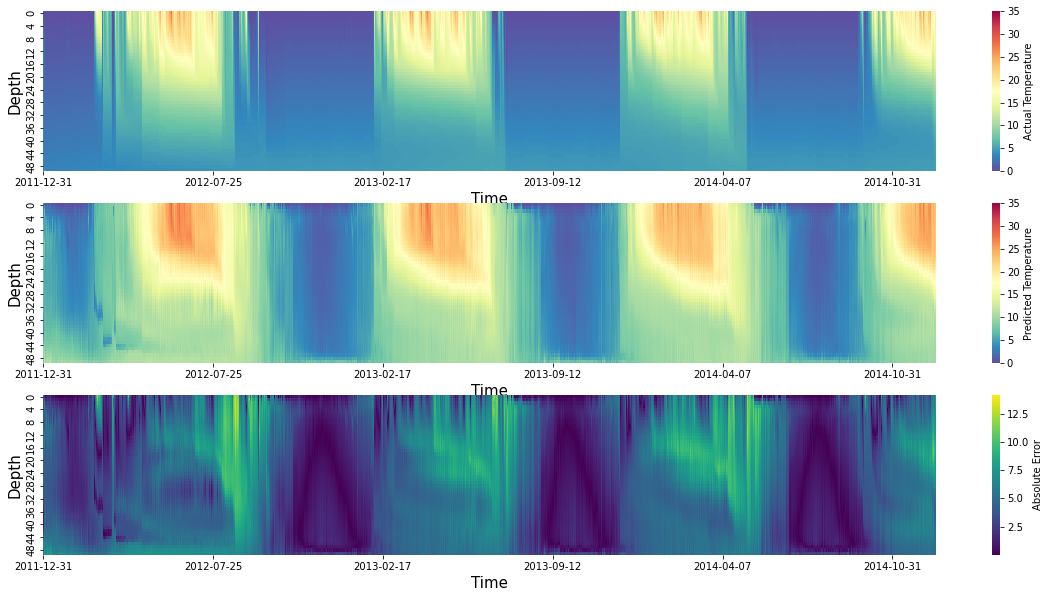

In [31]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

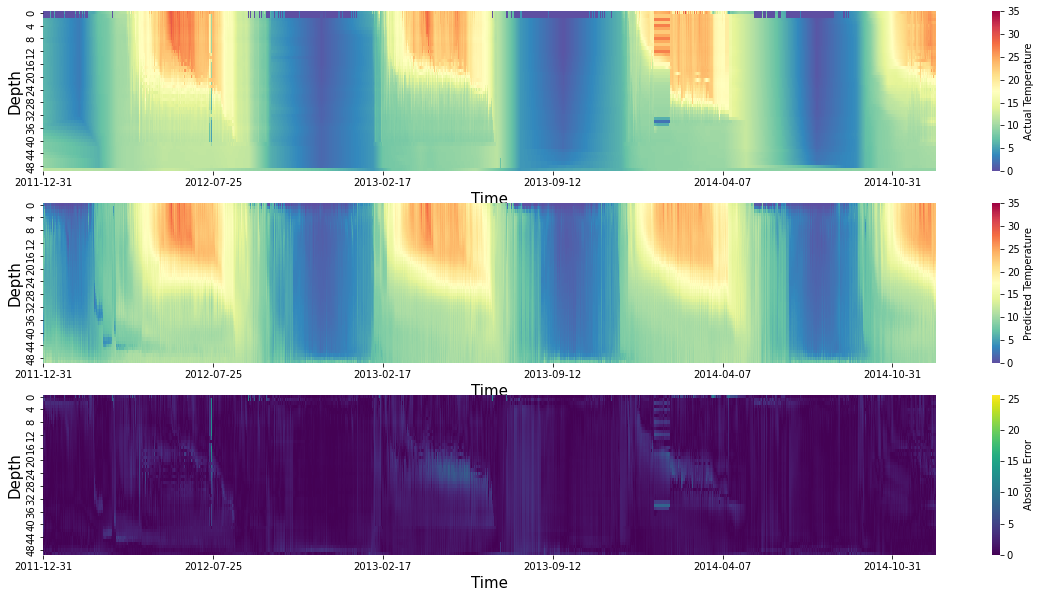

In [32]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [33]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(direct_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 6.731235
RMSE of after m0 6.7304487
RMSE of after m0 6.5420628
RMSE of after m0 6.4849057
RMSE of after m0 6.4987583
RMSE of after m0 6.5334597
RMSE of after m0 6.4767127
RMSE of after m0 6.425766
RMSE of after m0 6.56346
RMSE of after m0 6.758475
RMSE of after m0 6.622445
RMSE of after m0 6.5108023
RMSE of after m0 6.6614037
RMSE of after m0 6.3926253
RMSE of after m0 6.2420244
RMSE of after m0 6.4383116
RMSE of after m0 6.6766663
RMSE of after m0 6.988182
RMSE of after m0 7.1469517
RMSE of after m0 7.1211596
RMSE of after m0 7.0575156
RMSE of after m0 7.1608334
RMSE of after m0 7.7752357
RMSE of after m0 7.8155704
RMSE of after m0 7.5740128
RMSE of after m0 7.5307035
RMSE of after m0 7.5933995
RMSE of after m0 7.4555664
RMSE of after m0 7.2083063
RMSE of after m0 7.147382
RMSE of after m0 7.211025
RMSE of after m0 7.07843
RMSE of after m0 6.860547
RMSE of after m0 6.720729
RMSE of after m0 6.5536776
RMSE of after m0 6.5389237
RMSE of after m0 6.58813
RMSE of after m0

RMSE of after m0 3.3281212
RMSE of after m0 3.2219794
RMSE of after m0 3.214933
RMSE of after m0 3.1517806
RMSE of after m0 3.192301
RMSE of after m0 3.1957266
RMSE of after m0 3.1435423
RMSE of after m0 3.118741
RMSE of after m0 3.3180203
RMSE of after m0 3.3289526
RMSE of after m0 3.4046288
RMSE of after m0 3.6530273
RMSE of after m0 4.210054
RMSE of after m0 4.183018
RMSE of after m0 4.040545
RMSE of after m0 4.1276603
RMSE of after m0 4.256129
RMSE of after m0 4.3098593
RMSE of after m0 4.3899317
RMSE of after m0 4.497259
RMSE of after m0 4.589059
RMSE of after m0 4.5902877
RMSE of after m0 4.5651994
RMSE of after m0 4.34715
RMSE of after m0 4.4470115
RMSE of after m0 4.5408673
RMSE of after m0 4.587878
RMSE of after m0 4.548166
RMSE of after m0 4.5792603
RMSE of after m0 4.4849753
RMSE of after m0 4.4227424
RMSE of after m0 4.6213126
RMSE of after m0 4.558083
RMSE of after m0 4.7095118
RMSE of after m0 4.64956
RMSE of after m0 4.6975703
RMSE of after m0 4.8270254
RMSE of after m0 

RMSE of after m0 0.9494758
RMSE of after m0 0.90860045
RMSE of after m0 0.90958565
RMSE of after m0 0.90502715
RMSE of after m0 0.94680953
RMSE of after m0 1.0066992
RMSE of after m0 0.9946335
RMSE of after m0 0.8882841
RMSE of after m0 0.89272934
RMSE of after m0 0.9282122
RMSE of after m0 1.0366783
RMSE of after m0 1.0341336
RMSE of after m0 1.0434808
RMSE of after m0 1.1312983
RMSE of after m0 1.1544329
RMSE of after m0 1.0352542
RMSE of after m0 1.0184263
RMSE of after m0 1.1771818
RMSE of after m0 1.2196066
RMSE of after m0 1.2647476
RMSE of after m0 1.2849301
RMSE of after m0 1.2962083
RMSE of after m0 1.2871264
RMSE of after m0 1.2487751
RMSE of after m0 1.2493602
RMSE of after m0 1.2651212
RMSE of after m0 1.3416528
RMSE of after m0 1.3658774
RMSE of after m0 1.3662889
RMSE of after m0 1.5137209
RMSE of after m0 1.5417556
RMSE of after m0 1.4363179
RMSE of after m0 1.5330771
RMSE of after m0 1.3153154
RMSE of after m0 1.1671222
RMSE of after m0 1.1114458
RMSE of after m0 1.1068

RMSE of after m0 5.9103265
RMSE of after m0 5.6189027
RMSE of after m0 6.1091914
RMSE of after m0 6.3119473
RMSE of after m0 6.3090467
RMSE of after m0 6.8167076
RMSE of after m0 7.1220107
RMSE of after m0 7.1718917
RMSE of after m0 7.696913
RMSE of after m0 8.347751
RMSE of after m0 8.165136
RMSE of after m0 8.294494
RMSE of after m0 8.971998
RMSE of after m0 8.89924
RMSE of after m0 8.889457
RMSE of after m0 8.67631
RMSE of after m0 8.58258
RMSE of after m0 8.564456
RMSE of after m0 8.178887
RMSE of after m0 7.864296
RMSE of after m0 7.850379
RMSE of after m0 7.7849
RMSE of after m0 7.4133472
RMSE of after m0 7.466626
RMSE of after m0 7.8888927
RMSE of after m0 7.572095
RMSE of after m0 7.557206
RMSE of after m0 7.363718
RMSE of after m0 7.0151052
RMSE of after m0 7.058083
RMSE of after m0 7.327197
RMSE of after m0 7.0643115
RMSE of after m0 6.706835
RMSE of after m0 6.8155193
RMSE of after m0 6.6784286
RMSE of after m0 6.3990326
RMSE of after m0 6.2325015
RMSE of after m0 6.1751537


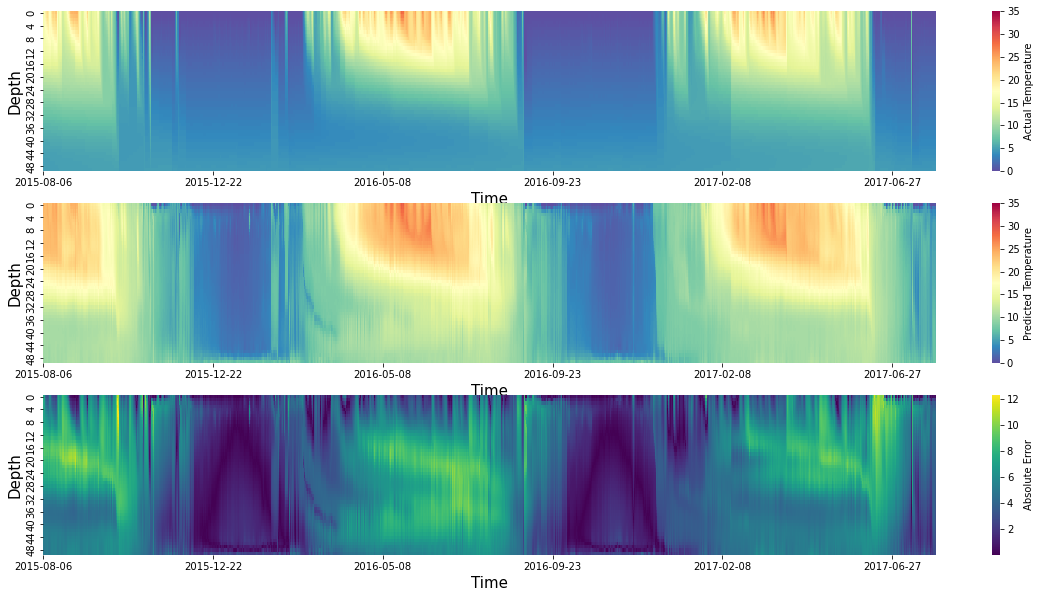

In [34]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

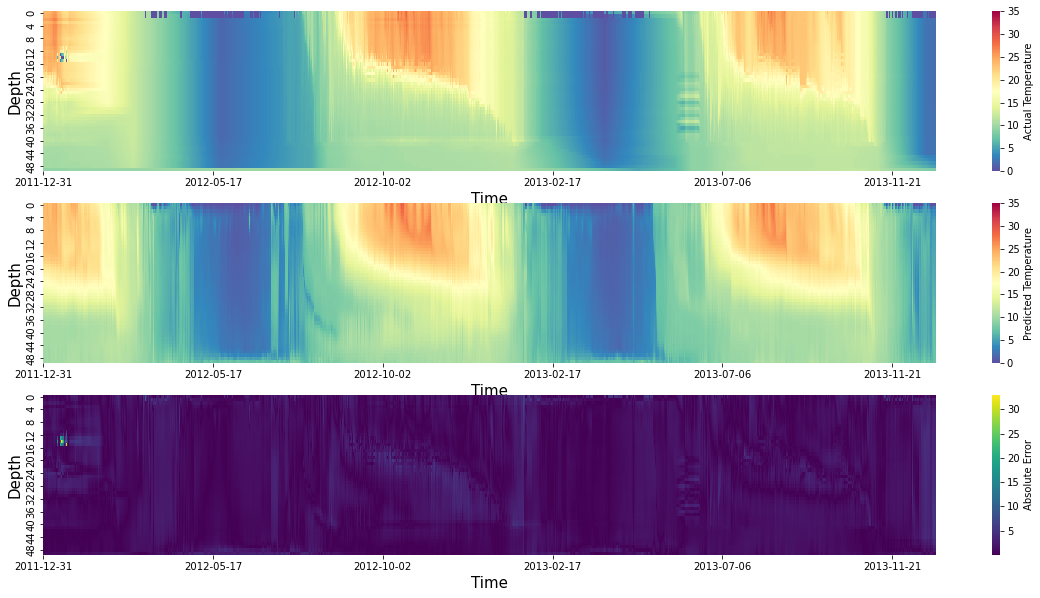

In [35]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

## Mixing Model

## Convection Model

## Ice Model

# Compute Model Similarity after Finetuning

In [36]:
# Freeze all models again and compute finetuned diffusivity values

In [37]:
# Unfreeze diffusion model and finetune it on projected diffusivities

In [38]:
PATH = f"./saved_models/directdeep_model_PB_finetuned.pth"
torch.save(direct_model.state_dict(), PATH)